# Исследование закономерностей, определяющих успешность игры

**Описание проекта**

Вы работаете в интернет-магазине по продаже видеоигр, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Данные за 2016 год могут быть неполными.

## Откроем файл с данными и изучим общую информацию ##

Импортируем необлодимые в дальнейшей работе библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

Поместим данные в переменную

In [2]:
data = pd.read_csv('/datasets/games.csv')

Посмотрим, что у нас имеется в датафрейме

In [4]:
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Получим общую информацию о данных путем применения функции *info*

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Первичный взгляд на имеющиеся данные выявил следующее:
- имеется 16714 строк с данными,
- названия столбцов имеют как заглавные, так и прописные символы,
- в ряде столбцов имеются пропуски в данных (это касается столбцов с названием игры, датой релиза, жанром, оценкой критиков, оценкой пользователей, возрастным рейтингом),
- столбец с оценкой пользователей несмотря на предположение, что оценки выражаются в числах, имеет тип данных object, надо будет рассмотреть его более пристально,
- есть возможность заменить типы данных на более подходящие, так дата релиза храниться в типе данных с плавующей точкой, что является излишним.

## Подготовка данных ##

1. Замените названия столбцов (приведите к нижнему регистру);
2. Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
3. Обработайте пропуски при необходимости:
  1. Объясните, почему заполнили пропуски определённым образом или почему не стали это делать
  2. Опишите причины, которые могли привести к пропускам
  3. Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать
4. Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

### Унификация названий столбцов ### 

Преобразуем название столбов в нижний регистр путем применения функции *str.lower*

In [6]:
data.columns = data.columns.str.lower()

### Обработка пропусков ###

Первичный анализ данных выявил пропуски.

Методом *isna()* в купе с *sum* примененным к датафрейму посмотрим сколько и где находиться пропусков.

In [7]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Как видим наибольшее количество пропусков касается столбцов, содержащих сведения о рейтингах, однако, ввиду невозможности применения иного способа кроме как поиска информации в других источниках и заполнение отсуствующих данных, оставим эти пропуски как есть.

Что касается природы наличия таких пропусков, то без наличия дополнительной информации откуда эти данные были выгружены, мы можем только некоторые предположения:
- Для оценок критиков и пользователей:
1. Если предположить, что "Стримчик" обладает собственными критиками, а также имеет возможность пользователям выставлять оценку,  то пропуски можно объяснить тем, что эти игры просто не были оценены.
2. Более вероятным видиться, что для отображения рейтинга, эти данные агрегируются со значимых для сообщества изданий, либо уже беруться данные с авторитетных агрегаторов, например *metacritic.com*, где, кстати, рейтинг также делиться оценки на критиков и пользователей. В таком случае можно говорить либо о какой-то ошибки выгрузки данных, либо, что данный агрегатор не содержит сведения о какой-то игре ввиду каких-то своих особенностей.
- Что касается рейтинга агенства ESRB.<br>
Данный рейтинг предполагает оценку игр для северо-американского региона, а сама организация была основана в 1994 году.
Таким образом рейтинг для игр, выпущенных для других регионов либо выпущенных ранее 94-го года, будет отсуствовать по объективным причинам.<br>

Конечно никогда не стоит исключать и человечкий фактор.


Что касается пропусков в *названии игры*, *года её выпуска* и *жанра*, целесообразным будет удалить эти строки. Тем более их вес в данной выборке менее 2% и, в конечном счёте, это не повлияет на дальнейший анализ.

Удалим пропуски методом *dropna*, где укажем интересующие нас столбцы в параметре subset.

In [8]:
data.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True)

Проверим данные на явные дубликаты методом *duplicated* в связке с *sum*.

In [9]:
data.duplicated().sum()

0

Вызовем числовое описание столбца с годом релиза методом *describe* для анализа на выдающиеся значения.

In [10]:
data['year_of_release'].describe()

count    16444.000000
mean      2006.486256
std          5.875525
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

История компьютерных игр начинается в 1940-х и 1950-х годах, следовательно, тот факт, что значения столбца *year_of_release* находятся в диапазоне от 1980 по 2016, свидетильствует о том, что анамалий нет.

Теперь рассмотрим более пристально столбы с катеригориальными данными (*platform*, *genre*, *rating*) на предмет неявных дубликатов.
Для этого изучим уникальные значения для каждого столбца методом *unique*, но прежде применим сортировку к датафрейму (*sort_values*), чтобы упорядочить список уникальных значений.

In [11]:
data.sort_values(by='platform')['platform'].unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [12]:
data.sort_values(by='genre')['genre'].unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

In [13]:
data.sort_values(by='rating')['rating'].unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Неявный дубликатов в списке платформ не имеется.

А вот что касается жанров, то неявный дубликатов здесь также нет, однако, есть значение ***misc***, что скорее всего обозначает "miscellaneous game", т.е. игры не вошедшие в предыдущие жанры.

В сведениях о рейтинге ESRB имеется значение ***K-A***, которое до 1999 года присваивалась играм категории "Для всех" и соответствует категории ***E*** в текущий редакции рейтинга. Для целей нашего анализа будет целесообразно актуализировать старые рейтинга на новый лад.

In [14]:
data.loc[data['rating'] =='K-A', 'rating'] = 'E'

Теперь посмотрим, нет ли аномальных значений в информации об оценках критиках, поскольку там храняться числовые значения применим метод *describe()*.

In [15]:
data['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Несмотря на пропуски, в остальном, значения находяться в пределах шкалы от 0 до 100 баллов, с максимальным баллом  в 98.

Принимая во внимание, что входе первичного анализа, было установленно, что столбец с оценками пользователей имеет тип object, для изучения данных взглянем на уникальные ххранящиеся уникальные значения.

In [16]:
data.sort_values(by='user_score')['user_score'].unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Обнаружилось, что рассматриваемый столбец содержит не только числовое выражение оценок в диапазоне от 0 до 10, но и  ***tbd***.<br> Предположим, что *tbd* - это аббревиатура от английского *To Be Determined (будет определено)*.

Поскольку, в дальнейшем, это может отразиться на наших вычислениях, заменим значение *tbd* на *nan* типа *float*, так данный рейтинг представлен значениями, имеющию дробную часть.

In [17]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

### Преобразование типа данных

Для изучения возможности преобразования типа данных получим информацию о датафреме.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Исходя из полученных сведений целеособразным представляется:
1. Оставить тип данных для столбца *name* без изменений, а также *critic_score*, т.к., к сожалению, невозможно преобразовать в целочисленный тип столбец, содержащий нулевые значения,
2. Изменить тип данных:
 1. на целочисленный для столбцов *year_of_release*(т.к. дата релиза представлена годом, а не точной датой, и в дальнейшей это отличие не будет иметь значимости в исследование), *critic_score*,
 2. на вещественный для столбца *user_score*.

Изменим тип данных столбцов *year_of_release* на целочисленный.

In [19]:
data['year_of_release'] = data['year_of_release'].astype(int)

Изменим тип данных столбца *user_score* на вещественный.

In [20]:
data['user_score'] = pd.to_numeric(data['user_score'])

Проверим результат проведенных манипуляций

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Наполнение таблицы дополнительными данными ###

Добавим в таблицу данные о суммарных продажах и поместим их в столбец *total_sales*.

In [22]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

Поставим столбец с информацией о суммарных продажах после столбцов с продажами по регионам.

In [23]:
data = data[['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales','jp_sales', 'other_sales', 'total_sales', 'critic_score', 'user_score', 'rating']]

## Проведем исследовательский анализ данных ##

В рамках анализа:
1. Посмотрим, сколько игр выпускалось в разные годы.
2. Изучим, как менялись продажи по платформам, а также выберем платформы с наибольшими суммарными продажами и построим распределение по годам.
3. Сделаем срез данных за актуальный период. *Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.*
4. Ответим на вопрос: какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
5. Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. *Опишите результат.*
6. Узнаем, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. *Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы. Соотнесите выводы с продажами игр на других платформах.*
7. Изучим общее распределение игр по жанрам. *Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?*

### Проведем анализ выхода игр в разные годы ###

Для этого построим график

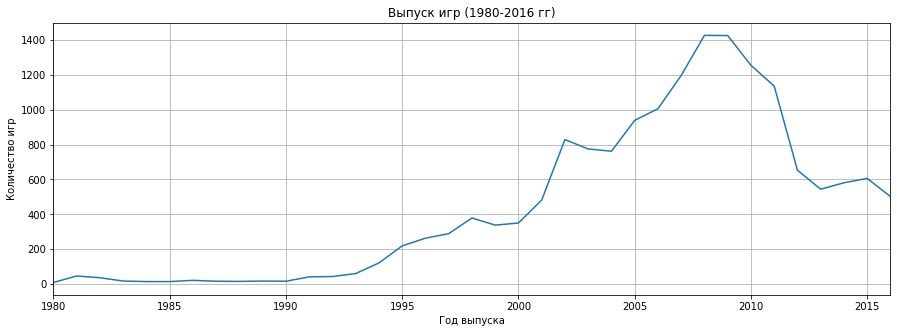

In [24]:
#Строим график
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(grid=True, figsize=(15,5), legend=False)
#Украшаем
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.title('Выпуск игр (1980-2016 гг)')
plt.show()

Как видим игровая индустрия развивалась постепенно, это обосновано скорее экономическими фкаторами. На первых порах развития рынка игровые видеосистемы и персональные компьютеры были слишком д*о*роги для подавляющего большинства граждан. Однако, в дальнейшем с развитием технического прогресса, усовершенствования производственных циклов, высокотехнологические устройства становились всё доступнее, что и дало старт к более стремительному развитию игровой индустрии.

Для нас, в рамках задач нашего иследования, историческая подоплека не имеет особого значения, и для анализа стоит выбрать наиболее актуальный период времени, который будет соотвествовать основным тенденциям в текущем периоде.

Этим мы и займемся в  дальнейшим.

### Изучим продажи в разрезе платформ  ### 

В целях изучения продаж игр в разрезе всех платформ построим график подсчёта.
Для этого обратимся к библиотеке *seaborn* и возьмем оттуда метод *scatterplot* для построения диаграммы рассеиванияю

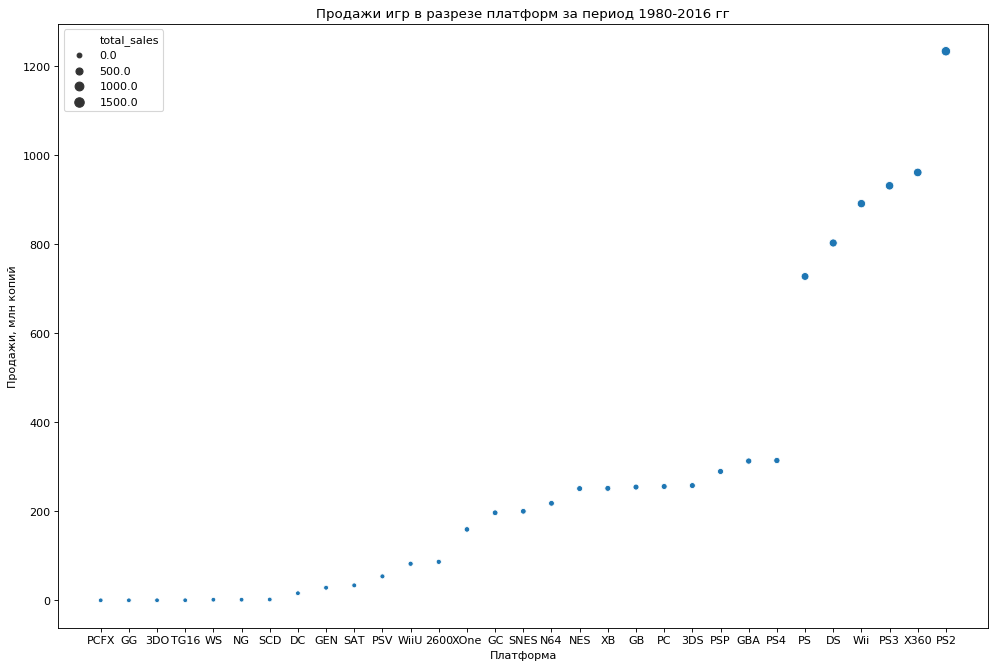

In [25]:
# Строим диаграмму рассеивания
fig, ax = plt.subplots(figsize=(15,10), dpi= 80)    
sns.scatterplot(data=data.groupby(by='platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=True).reset_index(), 
                x="platform", y="total_sales", size='total_sales')
# Украшаем
plt.title('Продажи игр в разрезе платформ за период 1980-2016 гг')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн копий')
plt.show()

Выберем 10 платформ с наибольшими суммарными продажами

Для этого создадим переменную в которую поместим 10 позиций от результата группировки методом *groupby* по столбцу *platform* с суммированием значений в столбце *total_sales* и сортировки по убыванию.

In [26]:
top_10_platform_by_sales = data.groupby(by='platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False).head(10).reset_index()
top_10_platform_by_sales.T

,0,1,2,3,4,5,6,7,8,9
platform,PS2,X360,PS3,Wii,DS,PS,PS4,GBA,PSP,3DS
total_sales,1233.56,961.24,931.34,891.18,802.78,727.58,314.14,312.88,289.53,257.81


Изучим распредление продаж по годам по полученному списку лидеров.



С помощью метода *tolist()* примененного к столбцу *platform* полученной выше переменной создадим библиотеку лидеров рынка.

In [27]:
list_of_top_10_platform_by_sales = top_10_platform_by_sales['platform'].tolist()

Метод *query* делаем срез данных по внешней библиотеке лидиров из которого формируем сводную таблицу, по которой в конечно счёте и строим график.

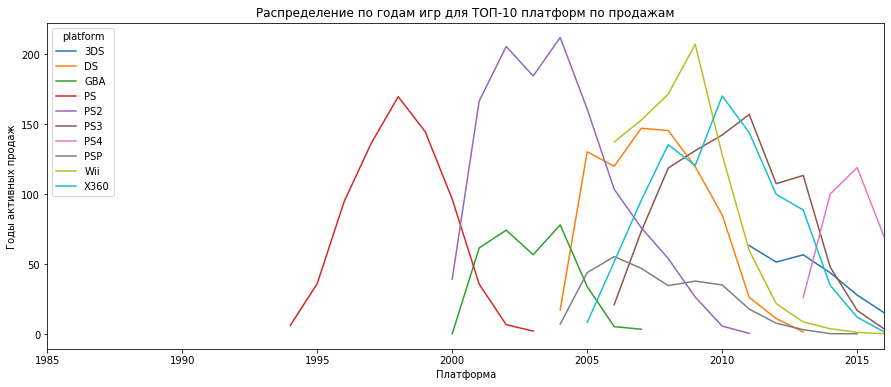

In [28]:
data.query('platform in @list_of_top_10_platform_by_sales').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(15,6))
#Украшаем
plt.title('Распределение по годам игр для ТОП-10 платформ по продажам')
plt.xlabel('Платформа')
plt.ylabel('Годы активных продаж')
plt.show()

Как видим и лидиры рынка имеют свои взлёты и падения, но в целом графики похожи на нормальное распределения.

Также следуют обратить внимание, что, если брать мир в целом, то персональные компьютеры (PC) не находяться в лидерох продаж, что нам, как гражданам пост-советского лагеря удивительно, но отражает реальную картину. Да, и будем, откровенны, количество пиратских копий не могло попасть изучаемые данные.

Теперь изучим жизненный цикл консоли, точнее его активную фазу, и только в общемировом срезе, т.к. в мире игровых видеосистем всегда найдуться исключения, так NES/Famicom (у нас больше известен как "DENDY", к слову неофициальный аппаратный клон) был популярен в нашем регионе в период, когда во всем мире уже правили бал другие консоли, а позже воцарил своё триумфальное шествие по странам латинской америки, но это обсуловленно скорее экономической ситуацией в странах в этот период нежели преданостью фанатов. И таких примеров можно привести ещё несколько. Но, пожалуй, не здесь место этим историям...

Для расчёта активной фазы жизненного цикла(АФЖЦ) поступим следующим образом: создадим функцию для одной строки, которая будет возращать расчётный срок АФЖЦ в годах для платформы как разницу конца и начала активной фазы продаж, учитывая следующие параметры (за исключением PC - для компьютеров будет возращать NaN, т.к. ПК - это отдельная история):
1. Начало активной фазы - это год появления первых продаж копий игр для платформы
2. Конец активной фазы - год, когда продажи составили менее 3 квартиля (75%), при этом во избежания попадания фазы роста мы отсекаем года по медиане для всех лет продаж для конкретной платформы.

Создади перемененную с итоговыми продажи по всем регионам в разрезе платформ и лет в которую поместим результат соотвествующей группировки. Для избавления от мультииндекса применим метод *reset_index()*.

In [29]:
total_by_platform_and_year = data.groupby(by=['platform','year_of_release']).agg({'total_sales':'sum'}).reset_index()

Определим функцию для одной строки и пропишем в ней ранее оговариваемые условия.

In [30]:
def platform_active_live(row):
    platform = row['platform']
    start = total_by_platform_and_year.loc[total_by_platform_and_year['platform'] == platform, 'year_of_release'].min()
    q75 = total_by_platform_and_year.loc[total_by_platform_and_year['platform'] == platform, 'total_sales'].quantile(0.75)
    median_year = total_by_platform_and_year.loc[total_by_platform_and_year['platform'] == platform, 'year_of_release'].median()
    finish = total_by_platform_and_year.loc[(total_by_platform_and_year['platform'] == platform) & (total_by_platform_and_year['total_sales'] <= q75) & (total_by_platform_and_year['year_of_release'] > median_year), 'year_of_release'].min()
    if platform != 'PC':
        return (finish-start)
    return 'NaN'

Применим фунцкию методом *apply* к ранее созданному датафрейму.

In [31]:
total_by_platform_and_year['platform_active_live'] = total_by_platform_and_year.apply(platform_active_live, axis=1)

Узнаем медиану для игровых консолей в целом.

In [32]:
total_by_platform_and_year['platform_active_live'].median()

6.0

Как видим активная фаза жизненного цикла для видеосистем составляет 6 лет, что в целом соответствуют мнению большинства игрового сообщества.

Конечно, консоли продолжают существовать и имееют своих фанатов и по истечению этого срока по ряду причин, обослувленных в своей массе экономическими соображениями (т.к. при появлению нового поколения консолей, устройства да и игры к ним становятся дешевле, а в первые годы ещё и обладают б*о*льшим разнообразием), но в целом вендоры находят аргументы для игровых студий, чтобы последние выпускали игры на актуальные платформы.

### Сделаем срез данных за актуальный период.  ###

Для дальнейшего анализа надо выбрать наиболее актуальный период времени, который будет соотвествовать основным тенденциям в текущем периоде.

Чтобы решить эту задачу следует ответить на несколько вопросов:
- Какие платформы актуальны сейчас?
- В какой фазе жизненного цикла они находяться?

Учитывая, что активная фаза жиненного цикла для игровых видеосистем составляет 6 лет, то актуальными платформами будут те, которые находяться в пределах  данного диапазона.

Для определения перечня актуальных платформ создадим функцию, которая вернет нам дату релиза первой игры для платформы, это и примем за старт продаж.

In [33]:
def first_release(row):
    platform = row['platform']
    start = total_by_platform_and_year.loc[total_by_platform_and_year['platform'] == platform, 'year_of_release'].min()
    return start

Применим функцию к датафрейму *total_by_platform_and_year*

In [34]:
total_by_platform_and_year['release_year'] = total_by_platform_and_year.apply(first_release, axis=1)

Создадим перечень актуальных платформ и поместим его в отдельную переменную.

In [35]:
actual_platform = total_by_platform_and_year.query('release_year >= 2010')['platform'].unique().tolist()

<div class="alert alert-info">
<b>Комментарий студента:</b> 
Реальность такова, что 6-7 лет - как раз для игровый консолей, что не есть как жизненный цикл, если брать актуальные на рынке консоли, то получается:<br>
- 9-е поколение - PlayStaion 5 / Xbox Series X/S - 2020 год,<br>
- 8-е поколение - PlayStation 4 / Xbox One - 2013 год,<br>
- 7-е поколение - PlayStation 3 / Xbox 360 - 2006/2005 годы,<br>
- 6-е поколение - PlayStation 2 / Xbox - 2000/2001 годы.<br><br>
Тут намеряно опущены обновления консолей (такие как PS4 Pro например) в рамках одного поколения, так как на выпуск игр для платформы это не влияет.
    
При этом выпуск игр ещё некоторое время осуществляется на предыдущие поколения.
    
    
Что касается трендов рынка, то согласен, логичнее смотреть на развитие актуального поколения, но только не в первый и второй год продаж, т.к. пользователи меняют консоли не так быстро по разным причинам.

Однако было где-то пояснение в slack, что надо смотреть актуальность по жизненному циклу, меня это смутило, но делал так. Сейчас поправлю.
<br>
</div>

Визиализиуем срез данных по продажам для актуальных платформ.

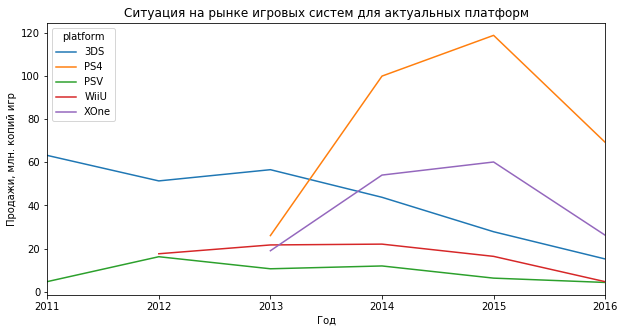

In [36]:
data.query('platform  in @actual_platform').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(10,5))
#Украшаем
plt.title('Ситуация на рынке игровых систем для актуальных платформ')
plt.xlabel('Год')
plt.ylabel('Продажи, млн. копий игр')
plt.show()

### Какие платформы лидируют по продажам, растут или падают? ###

Как мы можем видеть на графике, характеризующим ситуацию на рынке игровых консолей, на данный момент 3 платформы заврешают свой жизненый цикл, это Nintendo 3DS, Ninteno Wii U, Sony PlayStation Vita - их продажи стремяться к нулю. А консоли Sony Playstation 4 и Microsoft Xbox One только преодолели свой пик и наметили тренд на снижение продаж.

В рассматриваемом периоде времени потенциально прибыльными выглядят игровые приставки 8-го поколения (PS4 и XOne).

### Глобальные продажи игр в разбивке по платформам. ###

 В целях изучения лидеров глобального рынка продаж в разрезе платформ построим график «ящик с усами» методом *boxplot*.

Чтобы наш "ящик" приобрел более читаемый вид, и выбросы не растягивали его непомерно по вертикали, создадим список третьих квартилей лидеров рынка и поместим их переменную циклом.

In [37]:
q75_of_top_10_sales = []
for platform in list_of_top_10_platform_by_sales:
    q75_of_top_10_sales.append(data.loc[data['platform'] == platform,'total_sales'].quantile(0.75))

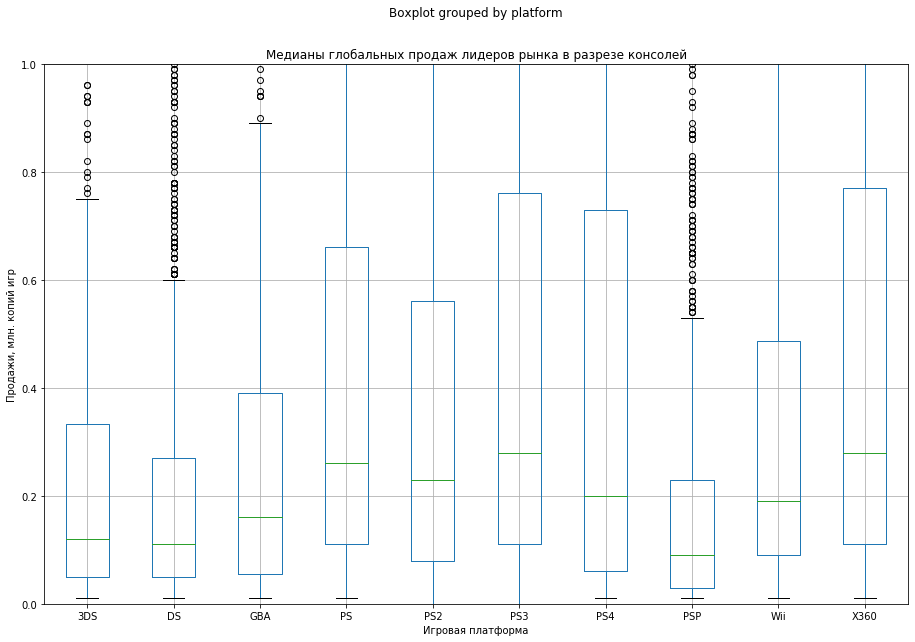

In [38]:
#Строим "ящик с усами"
data.query('platform in @list_of_top_10_platform_by_sales').boxplot(column='total_sales', by='platform', figsize=(15,10))
#Украшаем
# определим лимит по оси Y в диапазоне от 0 до округленного вверх до целого максимум 3 квартиля для списка лидеров
# это избавит нас от визуализации выбросов, так как нас они не интересуют
plt.ylim(0,np.ceil(max(q75_of_top_10_sales)))
plt.title('Медианы глобальных продаж лидеров рынка в разрезе консолей')
plt.xlabel('Игровая платформа')
plt.ylabel('Продажи, млн. копий игр')
plt.show()

Исходя из полученных данных, можно сделать однозначный вывод, что наилучшие медианные продажи составляют у стационарных консолей Sony: все поколения приставок Playstation преоделели отметку 0.2 млн.копий.

Также стоит обратить внимание, что в 7-м поколении Microsoft со своей Xbox 360 сравнялась со своим главным конкурентом в лице Playstation 3 от Sony. При этом Nintendo, представленная в этом поколении Wii, занимает 3 место не дотягивая до медианы в 200 тыс. копий игр.

Что касается портативных консолей, то тут несомненное лидерство за приставками от Nintendo: в списке лидеров находиться 3 приставки разного поколения (Game Boy Advance (GBA), Nintendo DS(DS), Nintendo 3DS(3DS)), против одной от Sony - PlayStation Portable(PSP). Если сравнивать портативные приставки, то из представленного списка сравнивать можно Nintendo DS и PlayStation Portable, так они были выпущены в аналогичный период, хоть показатели Sony и ниже, но в целом находяться на одном уровне.

### Влиянение на продажи внутри одной популярной платформы отзывов пользователей и критиков. ###

Для оценки влияния изучим лидера рынка для актуальных платформ по итогам продаж начиная с 2013 года. 

Определим лидера путем среза данных из основного массива с последующей группировкой и сортировкой по убывающей.<br>
К полученному срезу применим метод *head* с аргументом 1.

In [39]:
data.query('year_of_release >= 2013').pivot_table(index='platform', values="total_sales", aggfunc="sum").sort_values('total_sales', ascending=False).head(1)

,total_sales
platform,
PS4,314.14


Теперь узнаем коэффициент корреляции Пирсона методом *corr*, примененным к соответсвующей выборке.

In [40]:
data.loc[data['platform'] == 'PS4', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


Построим диграмму рассеивания.

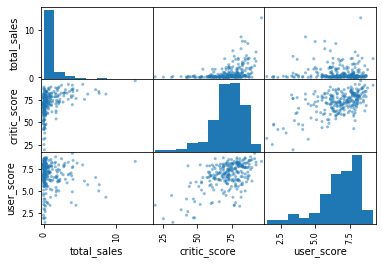

In [41]:
pd.plotting.scatter_matrix(data.loc[data['platform'] == "PS4", ['total_sales', 'critic_score', 'user_score']])
plt.show()

Исходя из полученных данных можно сделать вывод, что оценки критиков влияют на продажи по изучаемой платформе, т.к коэффициент Пирсона положителем и составляет 0,41, т.е. чем оценка больше, тем продажи лучше, но их влияние достаточно слабое что касаетя оценок пользователей, то они имееют обратную направленность и не оказывают влияние на продажи (коэффициент составляет (-0.03)).

Сравним полученный результат оценки влияния с аналогичными показателями для Sony Playstation 2 и Microsoft Xbox 360, которые занимают верхние строчки по суммарным продажам за весь период.

In [42]:
data.loc[data['platform'] == 'PS2', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.392536,0.175055
critic_score,0.392536,1.000000,0.565841
user_score,0.175055,0.565841,1.000000


In [43]:
data.loc[data['platform'] == 'X360', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.392866,0.114187
critic_score,0.392866,1.000000,0.625020
user_score,0.114187,0.625020,1.000000


Как видим, и по игровым приставкам предыдущего поколения наблюдалась взаимосвязь между оценками критиков и продажами игр, при этом можно говорить, что наблюдалось практически одинковое влияние, т.к. коэффициент Пирсона для обеих платформ составлял порядка 0,39, при этом следует обратить внимание, что в отличии от текущей ситации имело место положительное влияние и пользовательский рейтинг.

По моему мнению данную ситуацию следует рассматривать с точки зрения проникновения интернета в общество и его влияние на мнения, т.к. в то время веб-социализация была не столь существенной и при покупки игр большинство ориентировалось на профильные издания и мнения своего окружения, но это выходит за рамки нашего исседования, поэтому не будем уделять этому факту особое значение.

### Изучим общее распределение игр по жанрам. ###

Создадим переменную в которую поместим срез от основного датафрейма с данными за период, начиная с 2013 года, по всем платформам.

In [44]:
actual_total_sales = data.query('year_of_release >= 2013').groupby(by='genre').agg({'total_sales':'sum'}).reset_index().sort_values('total_sales', ascending=False)

Для визуализации построим круговую диаграмму.

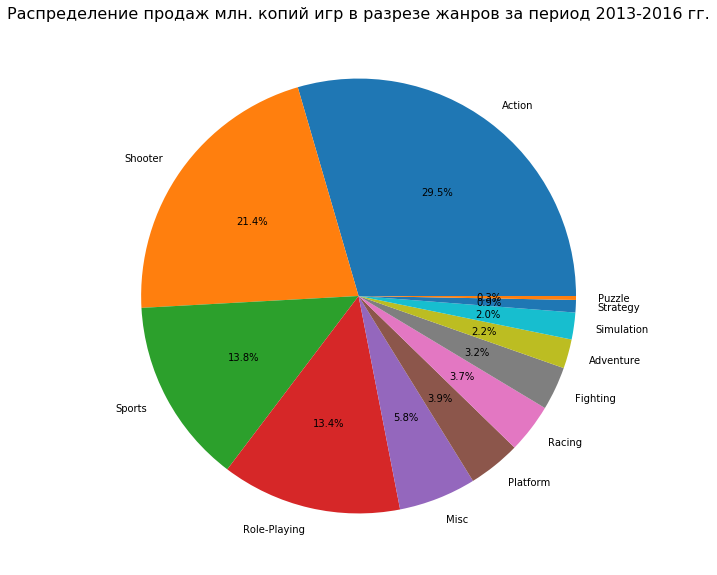

In [45]:
plt.pie(data=actual_total_sales, x='total_sales', labels=actual_total_sales['genre'],autopct='%1.1f%%')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title('Распределение продаж млн. копий игр в разрезе жанров за период 2013-2016 гг.', fontsize=16)
plt.show()

Как видим, основную массу продаж составляют игры жанра Active (29,5 %), далее следует с отрывом в 8,1% жанра Shooter, за ним жанр Sports и Role-Playing с 13,8% и 13,4% соответственно.

Рейтинг замыкают жанры Puzzle, Strategy и Adventure.

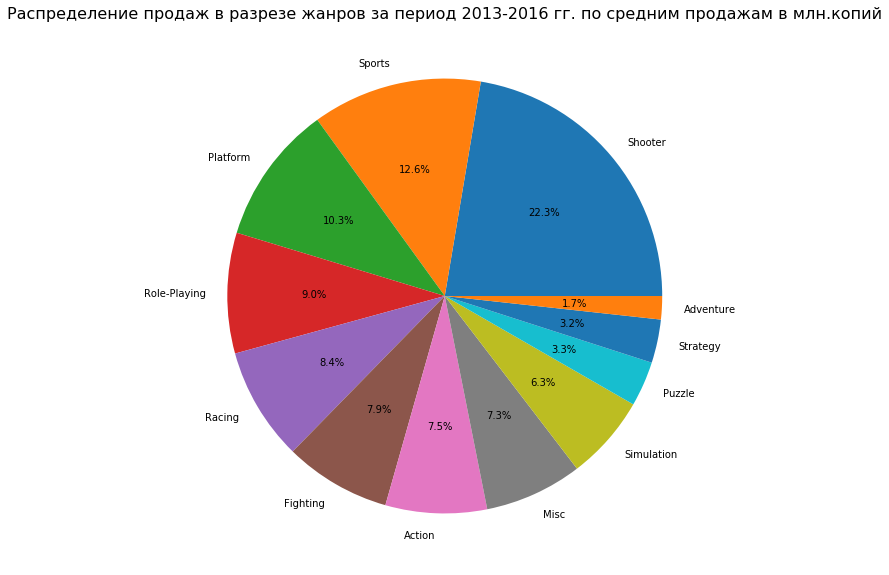

In [66]:
actual_total_sales_mean = data.query('year_of_release >= 2013').groupby(by='genre').agg({'total_sales':'mean'}).reset_index().sort_values('total_sales', ascending=False)
plt.pie(data=actual_total_sales_mean, x='total_sales', labels=actual_total_sales_mean['genre'],autopct='%1.1f%%')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title('Распределение продаж в разрезе жанров за период 2013-2016 гг. по средним продажам в млн.копий', fontsize=16)
plt.show()

Теперь изучим данные для наиболее актальных платформ на текущий момент - Sony Playstation 4, Microsoft Xbox One, а также добавим данные о продажах на персональных компьютерах за тот же период.

Продажи игр для PC хоть и не входят в сформированные лидеры, но исключать его не стоит, т.к. для данного типа устройств действуюет немного другая парадигма, тут актуальность платформы поддерживает сам пользователь модернизируя техническую часть своего устройства.

Создадим переменную куда поместим соотвествующие сгруппированные срезы с присоединением друг к другу методом *merge*.

In [46]:
sales_by_genre = (
    data.query('platform == "PS4"').groupby(by='genre').agg({'total_sales':'sum'}).reset_index().sort_values('total_sales', ascending=False).rename(columns={"total_sales": "PS4_total_sales"})
    .merge(data.query('platform == "XOne"').groupby(by='genre').agg({'total_sales':'sum'}).reset_index().sort_values('total_sales', ascending=False).rename(columns={"total_sales": "XOne_total_sales"}), on='genre')
    .merge(data.query('platform == "PC" & year_of_release >= 2013').groupby(by='genre').agg({'total_sales':'sum'}).reset_index().sort_values('total_sales', ascending=False).rename(columns={"total_sales": "PC_total_sales"}), on='genre')
)

Построим групповую столбчатую диаграмму на которой отобразим продажи по трем платформам одновременно.

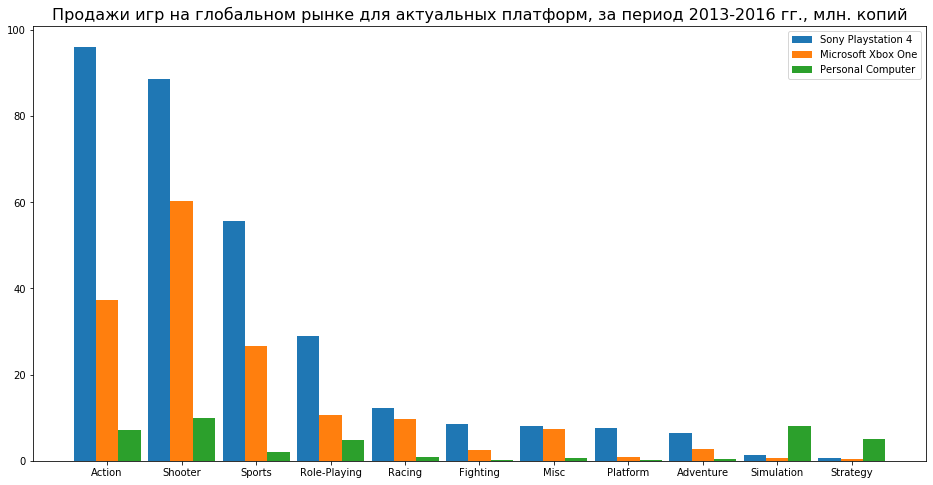

In [47]:
genres_name_in_sbg = sales_by_genre['genre'].tolist()

g1 = genres_name_in_sbg = sales_by_genre['PS4_total_sales'].tolist()
g2 = genres_name_in_sbg = sales_by_genre['XOne_total_sales'].tolist()
g3 = genres_name_in_sbg = sales_by_genre['PC_total_sales'].tolist()
width = 0.3
x = np.arange(len(genres_name_in_sbg))
fig, ax = plt.subplots()
fig.set_figwidth(16)    
fig.set_figheight(8)
rects1 = ax.bar(x - width, g1, width, label='Sony Playstation 4')
rects2 = ax.bar(x, g2, width, label='Microsoft Xbox One')
rects3 = ax.bar(x + width, g3, width, label='Personal Computer')
ax.set_title('Продажи игр на глобальном рынке для актуальных платформ, за период 2013-2016 гг., млн. копий', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(sales_by_genre['genre'].tolist())
ax.legend()
plt.show()

Как видим в целом тренд по популярности жанров одинаков для консолей: жанры Action и Shooter занимают первые места, что касается приставки от Microsoft, то здесь лидерство занимает жанр Shooter, что весьма предсказуемо, так как их эксклюзив Halo долгое время было топсейл и логично, что большинство игроков, предпочитающих этот жанр покупают в дальнейшем игр данного жанр больше.

Также стоит обратить внимание, что на PC жанры Simulation и Strategy имееют больший вес, чем на других платформах, это обсуловленно в первую очередь тем, что играть в них проще на клавиатуре и мыши.

## Портрет типичного игрока ##

В целях составления портрета типичного игрока раздлим пользователей на три категории в зависимости от региона и определим для них: 
- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).
<br>

Также изучим влияние рейтинга ESRB на продажи в отдельном регионе?

### Топ-5 платформ по регионам ###

Для анализа лидеров продаж копий игр по платформам в разрере регионов сгруппируем исходный данные с учётом необходимых требований, начиная с 2010 года.

In [48]:
data.query('year_of_release >= 2010').groupby(by='platform').agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False).head(5)

,na_sales
platform,
X360,334.18
PS3,229.25
Wii,121.20
PS4,108.74
XOne,93.12


In [49]:
data.query('year_of_release >= 2010').groupby(by='platform').agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False).head(5)

,eu_sales
platform,
PS3,213.60
X360,163.41
PS4,141.09
PC,68.82
Wii,65.91


In [50]:
data.query('year_of_release >= 2010').groupby(by='platform').agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False).head(5)

,jp_sales
platform,
3DS,100.62
PS3,59.26
PSP,42.20
DS,27.90
PSV,21.84


Как видим для рынков Северной Америки и Европы ситуация в целом схожа: лидируют игровые приставки от Microsoft и Sony, с той разницей что Xbox 360 преобладает в родном для себя регионе. 

Интересным образом распределились последующие места, так в европейском регионе тройку лидеров замыкает вышедшая в 2013 году консоль от Sony, аналогичное место в Новым Свете занимает игровая система от Nindento. Дальше в этом же регионе идут консоли актуального поколения, при этом PS4 вырывается вперед на 15.6 млн. копий продаж игр. 

Уникальным для рассматриваемых рынков является факт наличия в лидерах европейского региона - продажи игр для персональных компьютеров, которые заняли 4 место. Замыкает 5-у система от Nindendo.

Особая ситуация складывается в Японии. Здесь традиционно лидируют локальные производители, это и видно в ТОП-5: представлены консоли двух японский производителей Nintendo и Sony. Второй особенностью является широкое распостранение портативных игровых приставок, в топ-5 они занимают 4 места из 5 (по две от Nintendo 3DS И DS, и Sony PlayStation Portable и PlayStation Vita). Стационарная игровая видеосистема представлена только Sony PlayStation 3, которая расположилась на втором месте. 

### Топ-5 жанров по регионам

In [51]:
data.query('year_of_release >= 2010').groupby(by='genre').agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False).head(5)

,na_sales
genre,
Action,290.64
Shooter,237.47
Sports,156.81
Misc,123.80
Role-Playing,112.05


In [52]:
data.query('year_of_release >= 2010').groupby(by='genre').agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False).head(5)

,eu_sales
genre,
Action,233.63
Shooter,171.45
Sports,116.84
Role-Playing,75.48
Misc,66.09


In [53]:
data.query('year_of_release >= 2010').groupby(by='genre').agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False).reset_index().head(5)

,genre,jp_sales
0,Role-Playing,103.54
1,Action,72.20
2,Misc,24.29
3,Platform,15.81
4,Adventure,15.67


Опять же исходя из полученных данных можно однозначно сказать, что японский рынок уникален по своей сути и продажи игр по жанрам здесь совершенно иные, но начнём с изучения рынков Нового и Старого Света.

Что касается рынка Северной Америки и Европы, то мы видим, что перечень жанров для них одинаков, даже более того 3 первые строчки в нём занимают следующие жанры в порядке снижения продаж: Action, Shooter, Sports, оставшиеся два места занимают прочие игры и Role-Playing для америки, а для Европы - Role-Playing и прочие игры.

Исходя из топа 3 можно в целом высказать предположение, что видеоиграми в болшей степени интересуются представители мужского пола.

Что касается Японии, то тут лидером является жанр Role-Playing, далее следует Action. Третью строчку занимаеют прочие игры. А 4 и 5 место отданы Platform и Adventure, которые не встречаются в других регионах. Присутствие платформеров не удивительно, так как они наиболее распостранены на портативных консолях. В целом топ-5 нам говорит о большем увлечении населения видеоиграми в том числе и гендерном соотношении. Конечно, можно говорить о менталитите, а также о том, что исторически игровые консоли и аркадные системы получили большее распостранение в Японии. 

### Влияние рейтинга ESRB на продажи ### 

Взаимосвязь будем рассматривать в регионе к которому он относится - Северной Америке.


Учитывая влияние пропусков в значении рейтинга ESRB на дальнейший анализ вернемся к работе с пропусками в данном столбце за анализируемый период (2013+ год).

Вычислим долю пропусков.

In [54]:
round((data.loc[(data['rating'].isna())&(data['year_of_release'] >= 2013)&(data['na_sales'] > 0), 'platform'].count()/data.loc[(data['year_of_release'] >= 2013)&(data['na_sales'] > 0), 'platform'].count())*100,2)

22.77

22,77% пропусков окажет влияние на наш анализ, с целью не потерять данные, примем решение заменить пропуски в выборке на значение *unknown*.

In [55]:
data.loc[(data['rating'].isna())&(data['year_of_release'] >= 2013)&(data['na_sales'] > 0), 'rating'] = 'unknown'

Для начала посмотрим как распределены игры по рейтингу исходя из их количества. Воспользуемся круговой диаграммой.

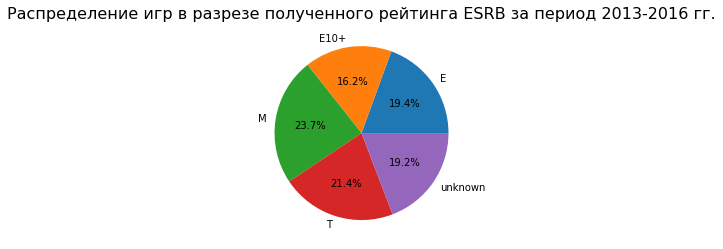

In [56]:
plt.pie(data=data.query('year_of_release >= 2013').groupby(by='rating').agg({'na_sales':'count'}), x='na_sales', labels=data.query('year_of_release >= 2013').groupby(by='rating').agg({'na_sales':'count'}).reset_index()['rating'],autopct='%1.1f%%')
plt.title('Распределение игр в разрезе полученного рейтинга ESRB за период 2013-2016 гг.', fontsize=16)
plt.show()

На полученную информацию будем опираться в дальнейшем.

В целях изучения влияния рейтинга на продажи в регионе построим диаграмму размаха.

Чтобы наш "ящик" приобрел более читаемый вид, и выбросы не растягивали его непомерно по вертикали, ограничем значения по оси *y* верхней границей края статистически значимой выборки (без выбросов), который находится по формуле ***q75 - 1.5(q75 - q25)***, округленной до целого вверх, для этого создадим список первых и третьих квартилей продаж в Северной Америке в разрезе ретинга и поместим их переменную циклом.

In [57]:
q75_of_na_sales_by_ESRB = []
q25_of_na_sales_by_ESRB = []
for rating in data['rating'].unique().tolist():
    q75_of_na_sales_by_ESRB.append(data.loc[(data['rating'] == rating)&(data['year_of_release'] >= 2013),'na_sales'].quantile(0.75))
    q25_of_na_sales_by_ESRB.append(data.loc[(data['rating'] == rating)&(data['year_of_release'] >= 2013),'na_sales'].quantile(0.25))

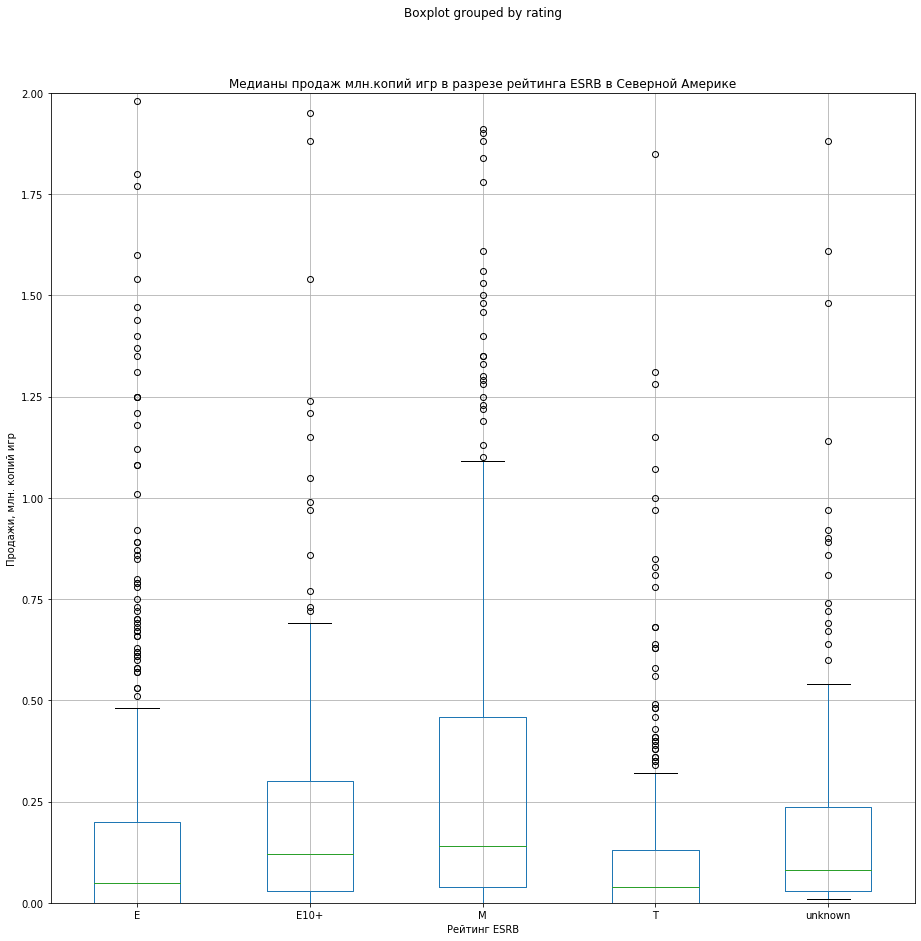

In [58]:
#Строим "ящик с усами"
data.query('year_of_release >= 2013').boxplot(column='na_sales', by='rating', figsize=(15,15))
#Украшаем
# определим лимит по оси Y в диапазоне от 0 до округленного вверх до целого максимум 3 квартиля
# это избавит нас от визуализации выбросов, так как нас они не интересуют
plt.ylim(0,np.ceil(max(q75_of_na_sales_by_ESRB)+1.5*(max(q75_of_na_sales_by_ESRB) - max(q25_of_na_sales_by_ESRB))))
plt.title('Медианы продаж млн.копий игр в разрезе рейтинга ESRB в Северной Америке')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи, млн. копий игр')
plt.show()

Для оценки влияния рейтинга ESRB на количество продаж надо разобраться, что он значит.

Рейтинг состоит из двух частей: знака рейтинга и краткого описания содержимого. Знак рейтинга определяет наиболее подходящую возрастную категорию для игры. В наших данных как раз и представлен этот рейтинг, без краткого описания содержания.

Таким образом:
- «RP» («Rating Pending») — «Рейтинг ожидается» (игра была отправлена в ESRB и ожидает присвоения рейтинга. Он используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу), в связи с чем данные о продажах будут отсуствоватью,
- «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет,
- «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет (Первоначально "K-A" ("Kids to Adults"),
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»,
- «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими,
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет,
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. 

Исходя из построенных диаграмм размаха можно сделать следующие выводы:
1. Как и предполагалось для игр с рейтингом "RP" продажи отсуствуют.
2. Наивышая медиана соответсвует играм для взрослых ("M") (их доля в выборке также наибольшая - 23,7%), при этом стоит отметить что для них характер наибольший межквартальный размах, а также наибольший верхний край выборки, что говорит нам скорее всего о более высокой стоимости копии игры и большей конкуренции, т.к. игры этого жанра обслуживают интересы наиболее платежеспособной части населений и свободной к выбору.
3. Второе место занимают игры категории "E10", но их доля занимает предпоследнее место и составляет 16,2 %.
4. Третье место за играми, данные о категории которых отсуствуют, учитывая значимую их долю (19,2%), при реальной анализе целесообразно заполнить недостающие сведения из других источников.
5. Игры категории "Е" и "Т" идут практически вровень, это касается и доли охвата (19,4% против 21,4%), это может сведетельствовать о том, что игровые компании нацелены, в б*о*льшей степени, на эти категории, как охватывающих наиболее полную аудиторию, что гарантирует определенный уровень дохода.

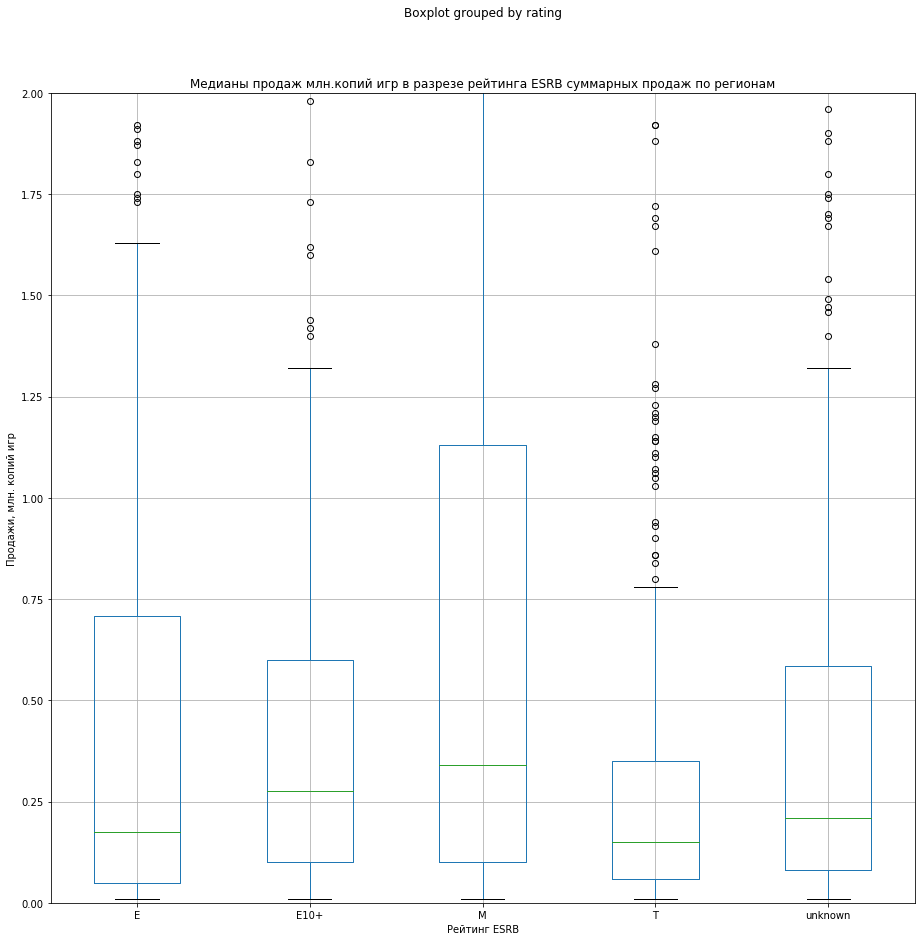

In [68]:
#Строим "ящик с усами"
data.query('year_of_release >= 2013').boxplot(column='total_sales', by='rating', figsize=(15,15))
#Украшаем
# определим лимит по оси Y в диапазоне от 0 до округленного вверх до целого максимум 3 квартиля
# это избавит нас от визуализации выбросов, так как нас они не интересуют
plt.ylim(0,np.ceil(max(q75_of_na_sales_by_ESRB)+1.5*(max(q75_of_na_sales_by_ESRB) - max(q25_of_na_sales_by_ESRB))))
plt.title('Медианы продаж млн.копий игр в разрезе рейтинга ESRB суммарных продаж по регионам')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи, млн. копий игр')
plt.show()

## Гипотезы ##
В рамках данного пункта нашего анализа, мы постраемся выяснить являются ли:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковыми;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различны.

Для проверки гипотиз уровень статистической значимости установим в 5%

In [59]:
alpha = .05

### Оценки пользователей для платформ Microsoft XBox One и PC ###

Рассмотрим оценки пользователей.
Для этого построим наши гипотизы следующим образом:

- Н0: Средние пользовательские рейтинги платформ Xbox One и PC равны
- Н1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются

Для проверки гипотизы применим метод st.ttest_ind, так как сравниваем две выборки.

In [60]:
revenue_results = st.ttest_ind(data.loc[data['platform'] == 'XOne','user_score'].dropna(), data.loc[(data['platform'] == 'PC')&(data['year_of_release'] >= 2010),'user_score'].dropna())

print('p-значение:', revenue_results.pvalue)

if revenue_results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC равны")

p-значение: 0.980998110649032
Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC равны


### Оценки пользователей жанров Action и Sports ###

Рассмотрим оценки пользователей.
Для этого построим наши гипотизы следующим образом:

- Н0: Средние пользовательские рейтинги жанров Action и Sports равны
- Н1: Средние пользовательские рейтинги жанров Action и Sports отличаются

Для проверки гипотизы применим метод st.ttest_ind, так как сравниваем две выборки.

In [61]:
revenue_results = st.ttest_ind(data.loc[(data['genre'] == 'Action')&(data['year_of_release'] >= 2010),'user_score'].dropna(), data.loc[(data['genre'] == 'Sports')&(data['year_of_release'] >= 2010),'user_score'].dropna())

print('p-значение:', revenue_results.pvalue)

if revenue_results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports равны")
    
print('Средние пользовательские рейтинги жанра Action составляют', round(data.loc[(data['genre'] == 'Action')&(data['year_of_release'] >= 2010),'user_score'].dropna().mean(),2))
print('Средние пользовательские рейтинги жанра Sports составляют', round(data.loc[(data['genre'] == 'Sports')&(data['year_of_release'] >= 2010),'user_score'].dropna().mean(),2))

p-значение: 7.839124224330309e-19
Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports отличаются
Средние пользовательские рейтинги жанра Action составляют 6.78
Средние пользовательские рейтинги жанра Sports составляют 5.9


## Общий вывод ##

Основной задачей анализа представленных данных было выявление закономерности, определяющие успешность игры. Данные закономерности в дальнейшем позволят сделать ставку на потенциально популярные продукты и спланировать рекламные компании.

Учитывая вышесказанное, а также принимая во внимание полученные в ходе исследования данные, можно сделать следующие выводы:
1. Активная фаза жизненного цикла для игровых видеосистем составляет 6 лет, данные знания позволят при дальнейшем прогнозе выявлять актуальные платформы и подстраивать рекламные бюджеты с оглядкой на то на каком промежутке находяться консоли. При этом следуют понимать, что данные сведения не относятся к играм для персональных компьютеров (PC).

   В текущем периоде (2017 год) потенциально прибыльными выглядят игровые приставки 8-го поколения (PS4 и XOne).

2. Существуют устойчивые тенденции, сложившиеся на региональны рынках, так для Северной Америки и Европы характерно более широкое распостранение стационарных игровых систем, при этом для Нового Света преобладают консоли от Microsoft. В Японии превалируют игровое приставки местных производителей со значительной долей портативных консолей.

3. Тенденция обособления рынка Японии сохраняеся и в разрезе жанров. Анализ рынков Северной Америки и Европы показал, что перечень жанров для них одинаков, даже более того 3 первые строчки в нём занимают следующие жанры в порядке снижения продаж: Action, Shooter, Sports, оставшиеся два места занимают прочие игры и Role-Playing для америки, а для Европы - Role-Playing и прочие игры. Что касается Японии, то тут лидером является жанр Role-Playing, далее следует Action. Третью строчку занимаеют прочие игры. А 4 и 5 место отданы Platform и Adventure, которые не встречаются в других регионах. Присутствие платформеров не удивительно, так как они наиболее распостранены на портативных консолях.

4. Одним из факторов, влияющих на продажи, высутпают оценки критиков, проведенный анализ показал наличие положительной зависимости оценок и продаж (коэфф. Пирсона составляет порядка 0,4). Оценки игроков для актуальных платформ имеют незначительное отрицательное влияние (коэфф. порядка (-0,03)), хотя в ретроперспективе имеел незначительное положительное влияния (порядка 0,1).

5. При проведении прогнозов следует принимать во внимание такой фактор как рейтинги специализирующихся агенств, проведя анализ связи рейтинга ESRB для северо-американского рынка, мы видим зависимость медианных продах от присваемого рейтинга. При этом стоит учитыать, что игровые студии ориентированы на выпуск в большей степени игр для широкого круга потребителей: игры категории "Е" и "Т" идут практически вровень, это касается и доли охвата (19,4% против 21,4%), и их медианы находяться практически на одном уровне, при этом игры для взрослых ("M"), имеют наибольший межквартальный размах, а также наибольший верхний край выборки, что говорит о более высокой стоимости копии игры и большей конкуренции, т.к. игры этого жанра обслуживают интересы наиболее платежеспособной части населений и необременных ограничениями в выборе.


Интересным фактом является соотвествие средних пользовательские рейтинги платформ Xbox One и PC. Это связь может свидетельствовать о слабой доле эксклюзивов для платформы от Microsoft и фактически одной игровой базы. Зная будущее мы можем сказать, что это была целенаправленная политика софтверного гиганта.